<a href="https://colab.research.google.com/github/maloyan/HW_keras/blob/master/hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#DON'T FORGET TO CHANGE Runtime->GPU

from tensorflow.keras.metrics import RootMeanSquaredError, AUC
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input, Lambda, concatenate
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
import tensorflow_addons as tfa
import tensorflow as tf
import albumentations as A

import os
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import random

import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

gc.enable()

%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
!nvidia-smi

Sun Jun 14 14:46:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [0]:
%%capture
!wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip;
!unzip ChestXRay2017.zip;
#!cd ./chest_xray && mkdir val && cd val && mkdir NORMAL && mkdir PNEUMONIA;

In [4]:
'''
TRAIN_SIZE = len(os.listdir('./chest_xray/train/NORMAL')) + len(os.listdir('./chest_xray/train/PNEUMONIA'))
for i in os.listdir('./chest_xray/train/NORMAL')[:(TRAIN_SIZE // 10)]:
    os.system(f'mv ./chest_xray/train/NORMAL/{i} ./chest_xray/val/NORMAL/{i}')

for i in os.listdir('./chest_xray/train/PNEUMONIA')[:(TRAIN_SIZE // 10)]:
    os.system(f'mv ./chest_xray/train/PNEUMONIA/{i} ./chest_xray/val/PNEUMONIA/{i}')
'''

"\nTRAIN_SIZE = len(os.listdir('./chest_xray/train/NORMAL')) + len(os.listdir('./chest_xray/train/PNEUMONIA'))\nfor i in os.listdir('./chest_xray/train/NORMAL')[:(TRAIN_SIZE // 10)]:\n    os.system(f'mv ./chest_xray/train/NORMAL/{i} ./chest_xray/val/NORMAL/{i}')\n\nfor i in os.listdir('./chest_xray/train/PNEUMONIA')[:(TRAIN_SIZE // 10)]:\n    os.system(f'mv ./chest_xray/train/PNEUMONIA/{i} ./chest_xray/val/PNEUMONIA/{i}')\n"

In [0]:
IMG_WIDTH, IMG_HEIGHT = 128, 128 #224, 224

TRAIN_DIR = './chest_xray/train/'
TEST_DIR = './chest_xray/test/'
#VAL_DIR = './chest_xray/val/'

EPOCHS = 30
BATCH = 8

TRAIN_SIZE = len(os.listdir('./chest_xray/train/NORMAL')) + len(os.listdir('./chest_xray/train/PNEUMONIA'))
#VAL_SIZE = len(os.listdir('./chest_xray/val/NORMAL')) + len(os.listdir('./chest_xray/val/PNEUMONIA'))

TRAIN_STEPS = TRAIN_SIZE // BATCH
#VAL_STEPS = VAL_SIZE // BATCH


if K.image_data_format() == 'channels_first':
    INPUT_SHAPE = (1, IMG_WIDTH, IMG_HEIGHT)
else:
    INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 1)

In [0]:
doc_aug = A.Compose([
    A.HorizontalFlip(p=0.8),
    A.ShiftScaleRotate(shift_limit=0.1625, scale_limit=0.2, rotate_limit=30, p=1)
], p=1)

NORMAL


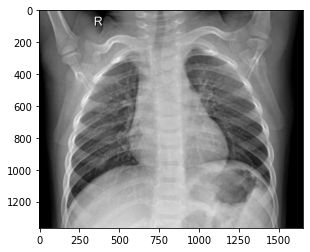

In [7]:
img_normal = cv2.imread('./chest_xray/train/NORMAL/' + os.listdir('./chest_xray/train/NORMAL')[0])

print('NORMAL')
plt.imshow(img_normal)
plt.show()

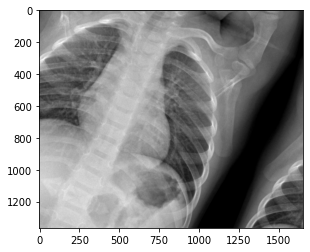

In [8]:
plt.imshow(doc_aug(image=img_normal, mask=None, bboxes=[], category_id=[])['image'])

PNEUMONIA


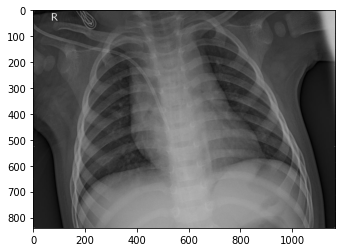

In [9]:
img_pneumonia = cv2.imread('./chest_xray/train/PNEUMONIA/' + os.listdir('./chest_xray/train/PNEUMONIA/')[0])

print('PNEUMONIA')
plt.imshow(img_pneumonia)
plt.show()

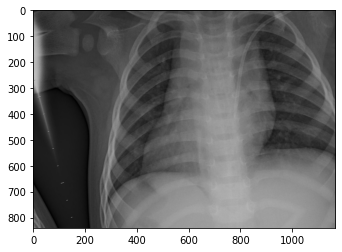

In [10]:
plt.imshow(doc_aug(image=img_pneumonia, mask=None, bboxes=[], category_id=[])['image'])

In [0]:
def loadimgs(path, train_flag=False):
    X = []
    y = []
    if train_flag:
        X_aug = []
        y_aug = []

    for ind, i in enumerate(['NORMAL', 'PNEUMONIA']):
        for file_path in os.listdir(path + '/' + i):
            if file_path[-5:] == '.jpeg':
                img = cv2.imread(path + '/' + i + '/' + file_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_AREA)
                # На каждую фотку делаем 1 аугментацию
                if train_flag:
                    for _ in range(1):
                        img_aug = doc_aug(image=img, mask=None, bboxes=[], category_id=[])['image']
                        img_aug = img_aug.reshape(IMG_WIDTH, IMG_HEIGHT, 1)
                        img_aug = img_aug.astype('float32')
                        img_aug /= 255
                        X_aug.append(img_aug)
                        y_aug.append(ind)

                img = img.reshape(IMG_WIDTH, IMG_HEIGHT, 1)
                img = img.astype('float32')
                img /= 255
                
                X.append(img)
                y.append(ind)
    if train_flag:
        return np.stack(X), np.stack(y), np.stack(X_aug), np.stack(y_aug)
    return np.stack(X), np.stack(y)

In [0]:
X_train, y_train, X_aug_train, y_aug_train = loadimgs('./chest_xray/train', train_flag=True)
#X_val, y_val = loadimgs('./chest_xray/val')
X_test, y_test = loadimgs('./chest_xray/test')

In [0]:
# Строим модель
# Она состоит из трех блоков вида: Свертка->Активация->MaxPooling

# После мы получаем признаки, которые запишем в одномерный массив с помощью Flatten
# Полносвязный слой выход 64->
# Активация Relu->
# 50% Дропаут ->
# Полносвязный слой с одним выходом->
# Нормализация с помощью Sigmoid

def base_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    '''
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    '''
    model.add(Flatten())
    model.add(Dense(64))

    return model

def classic_model(input_shape):
    
    model = base_model(input_shape)

    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    return model

def siamese_model(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    model = base_model(input_shape)

    model.add(Activation('sigmoid'))

    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([encoded_l, encoded_r])

    #prediction = Dense(1,activation='sigmoid')(L1_distance)

    siamese_net = Model(inputs=[left_input,right_input],outputs=distance)
    
    return model, siamese_net

def siamese_triplet_model(input_shape, triplet_margin=.3):

    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input")
    
    embedding_model = base_model(input_shape)
    
    # Generate the embedding outputs 
    encoded_anchor = embedding_model(anchor_input)
    encoded_positive = embedding_model(positive_input)
    encoded_negative = embedding_model(negative_input)
    
    inputs = [anchor_input, positive_input, negative_input]
    outputs = [encoded_anchor, encoded_positive, encoded_negative]
    
    # Connect the inputs with the outputs
    siamese_triplet = Model(inputs=inputs,outputs=outputs)
    
    siamese_triplet.add_loss((triplet_loss(outputs, dist='euclidean', margin='maxplus')))
    
    # return the model
    return embedding_model, siamese_triplet

In [0]:
def fit_nearest_neighbor(img_encoding, img_class, n_neighbors, algorithm='ball_tree'):
  classifier = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=algorithm)
  classifier.fit(img_encoding, img_class)
  return classifier

In [0]:
def training_evaluation(X_train, y_train, build_model, loss):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    recall    = []
    precision = []
    for i, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):

        model = build_model(INPUT_SHAPE)
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

        model.compile(
            loss=loss,
            optimizer=optimizers.Adam(),
            metrics=[
                tf.keras.metrics.Recall(), 
                tf.keras.metrics.Precision()
            ]
        )

        model.fit(
            x = X_train[train_index],
            y = y_train[train_index],
            batch_size=BATCH,
            epochs=EPOCHS,
            validation_data=(X_train[valid_index], y_train[valid_index]),
            callbacks=[callback],
            verbose=0
        )
        eval = model.evaluate(X_test, y_test)
        precision.append(eval[1])
        recall.append(eval[2])
        gc.collect()

    #print('RECALL: ', np.mean(precision), np.std(precision))
    #print('PRECISION: ', np.mean(recall), np.std(recall))
    return precision, recall

In [0]:
#CLASSIC

In [65]:
X_train.shape

(5232, 128, 128, 1)

In [17]:
precision, recall = training_evaluation(X_train, y_train, classic_model, tf.keras.losses.BinaryCrossentropy())

Epoch 1/30
131/131 [==============================] - 6s 48ms/step - loss: 0.3814 - recall: 0.9665 - precision: 0.8344 - val_loss: 0.1608 - val_recall: 0.9884 - val_precision: 0.9423
Epoch 2/30
131/131 [==============================] - 5s 42ms/step - loss: 0.1798 - recall: 0.9559 - precision: 0.9434 - val_loss: 0.1003 - val_recall: 0.9897 - val_precision: 0.9625
Epoch 3/30
131/131 [==============================] - 5s 42ms/step - loss: 0.1334 - recall: 0.9691 - precision: 0.9641 - val_loss: 0.0880 - val_recall: 0.9768 - val_precision: 0.9794
Epoch 4/30
131/131 [==============================] - 5s 42ms/step - loss: 0.1235 - recall: 0.9739 - precision: 0.9671 - val_loss: 0.0772 - val_recall: 0.9858 - val_precision: 0.9821
Epoch 5/30
131/131 [==============================] - 5s 42ms/step - loss: 0.1177 - recall: 0.9768 - precision: 0.9669 - val_loss: 0.0796 - val_recall: 0.9884 - val_precision: 0.9783
Epoch 6/30
131/131 [==============================] - 6s 42ms/step - loss: 0.0922 - r

In [18]:
print('RECALL: ', np.mean(precision), np.std(precision))
print('PRECISION: ', np.mean(recall), np.std(recall))

RECALL:  0.9958974242210388 0.0012561339110737652
PRECISION:  0.7277669072151184 0.010714564595903878


In [90]:
gc.collect()

2590

In [0]:
precision, recall = training_evaluation(
    np.append(X_train, X_aug_train, axis=0), 
    np.append(y_train, y_aug_train, axis=0), 
    classic_model, 
    tf.keras.losses.BinaryCrossentropy()
)

20/20 [==============================] - 0s 11ms/step - loss: 2.7377 - recall_8: 0.9897 - precision_8: 0.7510


In [0]:
print('RECALL: ', np.mean(precision), np.std(precision))
print('PRECISION: ', np.mean(recall), np.std(recall))

RECALL:  0.7327021718025207 0.010558717900158833
PRECISION:  0.9943589687347412 0.002512289722310107


In [0]:
gc.collect()

0

In [0]:
precision, recall = training_evaluation(X_train, y_train, classic_model, tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1))

20/20 [==============================] - 0s 11ms/step - loss: 0.7472 - recall_13: 0.9974 - precision_13: 0.6959


In [0]:
print('RECALL: ', np.mean(precision), np.std(precision))
print('PRECISION: ', np.mean(recall), np.std(recall))

RECALL:  0.7041002631187439 0.01866457097335102
PRECISION:  0.9943589568138123 0.004971967978646425


In [0]:
gc.collect()

0

In [0]:
precision, recall = training_evaluation(
    np.append(X_train, X_aug_train, axis=0), 
    np.append(y_train, y_aug_train, axis=0),  
    classic_model, 
    tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1))

20/20 [==============================] - 0s 11ms/step - loss: 0.6223 - recall_18: 0.9923 - precision_18: 0.7457


In [0]:
print('RECALL: ', np.mean(precision), np.std(precision))
print('PRECISION: ', np.mean(recall), np.std(recall))

RECALL:  0.7328256964683533 0.022285063533486513
PRECISION:  0.9948717713356018 0.0032433709337474233


In [16]:
#contrastive_loss

gc.collect()

5604

In [0]:
num_classes = 2

def create_pairs(x, y):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            
            dn = (d + 1) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


In [0]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [0]:
def training_evaluation_siamese(X, y, build_model, loss):
    recall    = []
    precision = []

    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    #skf_split = skf.split(X_train[0], y_train)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
        embedding_model, model = build_model(INPUT_SHAPE)
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
        
        tr_pairs = X[train_index]
        vl_pairs = X[valid_index]
        gc.collect()
        
        model.compile(
            loss=loss,
            optimizer=optimizers.Adam(),
        )

        model.fit(
            x = [tr_pairs[:, 0], tr_pairs[:, 1]],
            y = y[train_index],
            batch_size=BATCH,
            epochs=EPOCHS,
            validation_data=([vl_pairs[:, 0], vl_pairs[:, 1]], y[valid_index]),
            callbacks=[callback],
            verbose=0
        )

        train_embeds = embedding_model.predict(X_train)
        classifier = fit_nearest_neighbor(train_embeds, y_train, 10)
        e = embedding_model.predict(X_test)
        op = classifier.predict(e)

        m = tf.keras.metrics.Precision()
        _ = m.update_state(op, y_test)
        precision.append(m.result().numpy())

        m = tf.keras.metrics.Recall()
        _ = m.update_state(op, y_test)
        recall.append(m.result().numpy())

        gc.collect()

    return precision, recall, e

In [0]:
# create training+test positive and negative pairs
tr_pairs, tr_y = create_pairs(X_train, y_train)
te_pairs, te_y = create_pairs(X_test, y_test)

In [0]:
gc.collect()
precision, recall, e = training_evaluation_siamese(
    tr_pairs, 
    tr_y,
    siamese_model, 
    contrastive_loss
)

Epoch 1/3
135/135 [==============================] - 7s 55ms/step - loss: 0.1190 - val_loss: 0.0653
Epoch 2/3
135/135 [==============================] - 7s 51ms/step - loss: 0.0511 - val_loss: 0.0387
Epoch 3/3
135/135 [==============================] - 7s 55ms/step - loss: 0.0337 - val_loss: 0.0293
Epoch 1/3
135/135 [==============================] - 7s 49ms/step - loss: 0.1862 - val_loss: 0.0711
Epoch 2/3
135/135 [==============================] - 6s 47ms/step - loss: 0.0581 - val_loss: 0.0469
Epoch 3/3
135/135 [==============================] - 9s 63ms/step - loss: 0.0367 - val_loss: 0.0352
Epoch 1/3
135/135 [==============================] - 7s 51ms/step - loss: 0.1227 - val_loss: 0.0597
Epoch 2/3
135/135 [==============================] - 7s 50ms/step - loss: 0.0508 - val_loss: 0.0536
Epoch 3/3
135/135 [==============================] - 7s 50ms/step - loss: 0.0370 - val_loss: 0.0285
Epoch 1/3
135/135 [==============================] - 7s 49ms/step - loss: 0.1576 - val_loss: 0.0681


In [0]:
print('RECALL: ', np.mean(precision), np.std(precision))
print('PRECISION: ', np.mean(recall), np.std(recall))

RECALL:  0.99333334 0.002051285
PRECISION:  0.7345829 0.005750511


In [0]:
tr_aug_pairs, tr_aug_y = create_pairs(np.append(X_train, X_aug_train, axis=0), np.append(y_train, y_aug_train, axis=0))
te_pairs, te_y = create_pairs(X_test, y_test)

In [0]:
gc.collect()
precision, recall, e = training_evaluation_siamese(
    tr_aug_pairs, 
    tr_aug_y,
    siamese_model, 
    contrastive_loss
)

In [80]:
print('RECALL: ', np.mean(precision), np.std(precision))
print('PRECISION: ', np.mean(recall), np.std(recall))

RECALL:  0.99230766 0.003243352
PRECISION:  0.7166772 0.015238033


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=50, random_state=42).fit_transform(e)
viz_df = pd.DataFrame({'x': X_embedded[:, 0], 'y': X_embedded[:, 1]})

viz_df['color'] = ["#56E813" if i == 0 else "#0059FF" for i in y_test] 

# plot
sns.regplot(data=viz_df, x="x", y="y", fit_reg=False, scatter_kws={'facecolors':viz_df['color']})

In [0]:
#Triplet v2
gc.collect()

In [0]:
def generate_triplets(dataset, label, sample_per_class=10):
  x, y = None, None
  for i in range(2):
    pos_indices = np.argwhere(label == i)[:,0]
    neg_indices = np.argwhere(label != i)[:,0]

    # print("pos indices: {}, neg_indices: {}".format(pos_indices.shape, neg_indices.shape))
    choice_anchor = np.random.choice(pos_indices.shape[0], sample_per_class, replace=False)
    choice_anchor = pos_indices[choice_anchor]

    choice_pos = np.random.choice(pos_indices.shape[0], sample_per_class, replace=False)
    choice_pos = pos_indices[choice_pos]

    choice_neg = np.random.choice(neg_indices.shape[0], sample_per_class, replace=False)
    choice_neg = neg_indices[choice_neg]

    sub_x_anc = dataset[choice_anchor]
    
    sub_x_pos = dataset[choice_pos]

    sub_x_neg = dataset[choice_neg]
      
        
    if(x is None):
      x = [(sub_x_anc), (sub_x_pos), (sub_x_neg)]
      y = [label[choice_anchor], label[choice_pos], label[choice_neg]]
    else:
      x[0] = np.vstack((x[0], (sub_x_anc)))
      x[1] = np.vstack((x[1], (sub_x_pos)))
      x[2] = np.vstack((x[2], (sub_x_neg)))

      y[0] = np.hstack((y[0].flatten(), label[choice_anchor].flatten()))
      y[1] = np.hstack((y[1].flatten(), label[choice_pos].flatten()))
      y[2] = np.hstack((y[2].flatten(), label[choice_neg].flatten()))
    
  return x, y

def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, 1 + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
    return K.mean(loss)


In [0]:
def training_evaluation_siamese_triple(X, y, build_model):
    recall    = []
    precision = []

    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for i, (train_index, valid_index) in enumerate(skf.split(X[0], y[0])):
        embedding_model, model = build_model(INPUT_SHAPE)
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
        
        tr_pairs = [X[0][train_index], X[1][train_index], X[2][train_index]]
        vl_pairs = [X[0][valid_index], X[1][valid_index], X[2][valid_index]]
  
        tr_y = [y[0][train_index], y[1][train_index], y[2][train_index]]
        vl_y = [y[0][valid_index], y[1][valid_index], y[2][valid_index]]

        model.compile(
            loss=None,
            optimizer=optimizers.Adam(),
        )
        model.fit(
            x = tr_pairs,
            y = tr_y,
            batch_size=BATCH,
            epochs=EPOCHS,
            validation_data=(vl_pairs, vl_y),
            callbacks=[callback],
            verbose=0
        )

        train_embeds = embedding_model.predict(X_train)
        classifier = fit_nearest_neighbor(train_embeds, y_train, 10)
        e = embedding_model.predict(X_test)
        op = classifier.predict(e)

        m = tf.keras.metrics.Precision()
        _ = m.update_state(op, y_test)
        precision.append(m.result().numpy())

        m = tf.keras.metrics.Recall()
        _ = m.update_state(op, y_test)
        recall.append(m.result().numpy())

        gc.collect()

    return precision, recall, e

In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [0]:
train_x, train_y = generate_triplets(X_train, y_train, 1349)
#val_x, val_y = generate_triplets(X_val, y_val, 100)
#test_x, test_y = generate_triplets(X_test, y_test, 100)

In [0]:
train_aug_x, train_aug_y = generate_triplets(np.append(X_train, X_aug_train, axis=0), np.append(y_train, y_aug_train, axis=0), 500)

In [0]:
gc.collect()
precision, recall, e = training_evaluation_siamese_triple(
    train_x, 
    train_y,
    siamese_triplet_model
)

In [106]:
print('RECALL: ', np.mean(precision), np.std(precision))
print('PRECISION: ', np.mean(recall), np.std(recall))

RECALL:  0.9897436 0.004290557
PRECISION:  0.7292192 0.0089178365


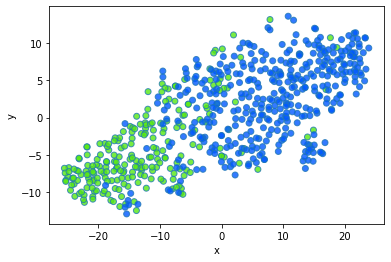

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=50, random_state=42).fit_transform(e)
viz_df = pd.DataFrame({'x': X_embedded[:, 0], 'y': X_embedded[:, 1]})

viz_df['color'] = ["#56E813" if i == 0 else "#0059FF" for i in y_test] 

# plot
sns.regplot(data=viz_df, x="x", y="y", fit_reg=False, scatter_kws={'facecolors':viz_df['color']})

In [0]:
embedding_model, siamese_triplet = siamese_triplet_model(INPUT_SHAPE, triplet_margin=.3)
siamese_triplet.compile(
    loss=None, #tfa.losses.TripletSemiHardLoss(), 
    optimizer=optimizers.Adam())

siamese_triplet.fit(
    x=train_x,
    y=train_y, 
    shuffle=True, 
    batch_size=BATCH, 
    epochs=EPOCHS,
    validation_data=(val_x, val_y)
)

In [95]:
for i, (train_index, valid_index) in enumerate(skf.split(train_x[0], train_y[0])):
    embedding_model, siamese_triplet = siamese_triplet_model(INPUT_SHAPE, triplet_margin=.3)
    siamese_triplet.compile(
        loss=None, #tfa.losses.TripletSemiHardLoss(), 
        optimizer=optimizers.Adam())

    siamese_triplet.fit(
        x=[train_x[0][train_index], train_x[1][train_index], train_x[2][train_index]],
        y=[train_y[0][train_index], train_y[1][train_index], train_y[2][train_index]], 
        shuffle=True, 
        batch_size=BATCH, 
        epochs=EPOCHS,
        #validation_data=(val_x, val_y)
    )

Epoch 1/30
270/270 [==============================] - 4s 16ms/step - loss: 0.2406
Epoch 2/30
270/270 [==============================] - 4s 16ms/step - loss: 0.1481
Epoch 3/30
270/270 [==============================] - 4s 16ms/step - loss: 0.1061
Epoch 4/30
 72/270 [=======>......................] - ETA: 3s - loss: 0.0651

KeyboardInterrupt: ignored

In [0]:
train_embeds = embedding_model.predict(np.vstack((train_x[0], train_x[1], train_x[2])))
target = np.hstack(train_y)
classifier = fit_nearest_neighbor(train_embeds, target, 10)
e = embedding_model.predict(X_test)
op = classifier.predict(e)
print((np.where(y_test == op))[0].shape[0] / y_test.shape[0])

In [0]:
gc.collect()

In [0]:
embedding_model, siamese_triplet = siamese_triplet_model(INPUT_SHAPE, triplet_margin=.3)
siamese_triplet.compile(
    loss=None, #tfa.losses.TripletSemiHardLoss(), 
    optimizer=optimizers.Adam())

siamese_triplet.fit(
    x=train_aug_x,
    y=train_aug_y, 
    shuffle=True, 
    batch_size=BATCH, 
    epochs=EPOCHS,
    validation_data=(val_x, val_y)
)

In [0]:
train_embeds = embedding_model.predict(np.vstack((train_x[0], train_x[1], train_x[2])))
target = np.hstack(train_y)
classifier = fit_nearest_neighbor(train_embeds, target, 10)
e = embedding_model.predict(X_test)
op = classifier.predict(e)
print((np.where(y_test == op))[0].shape[0] / y_test.shape[0])

In [0]:
gc.collect()